# Importancion librerías necesarias

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram

In [2]:
df = pd.read_csv('../data/clean_df.csv')
df.head(2)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,10.970592,0,0,58,6.455199,4.488636,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,10.743869,1,1,38,2.484907,0.693147,...,5,0,0,0,0,0,0,3,11,0


In [3]:
coeficientes = {}

### Seleccion de variables 

In [4]:
df.select_dtypes(include='object').columns

Index(['Education', 'Marital_Status'], dtype='object')

In [5]:
#Variables a utilizar para el modelo (retirando categrocias para que el modelo entienda mejor y tambien quitando id )
df_cop = df.copy()
df_cop = df_cop.drop(['Education', 'Marital_Status', 'ID'], axis=1) #Retiramos id en este ya que acá solo vamos a probar para definir un modelo
df_cop.head(2)

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,1957,10.970592,0,0,58,6.455199,4.488636,6.304449,5.153292,4.488636,...,7,0,0,0,0,0,0,3,11,1
1,1954,10.743869,1,1,38,2.484907,0.693147,1.945910,1.098612,0.693147,...,5,0,0,0,0,0,0,3,11,0


In [6]:
#Datos a utilizar
X = df_cop
#Datos estandarizados
scaler = StandardScaler()
X_standr = scaler.fit_transform(X)

### Aplicar PCA 

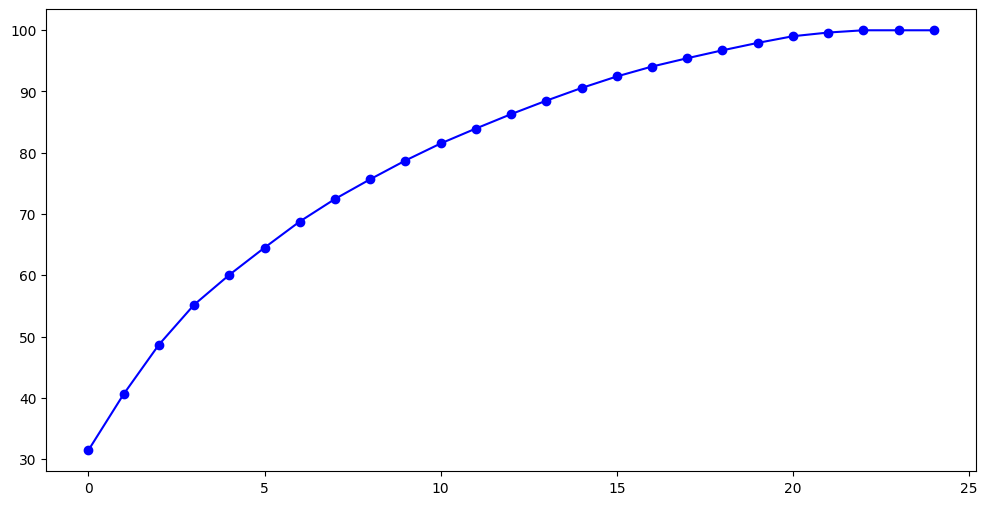

In [7]:
#Aplicación de PCA para probar con y sin pca cual es mas optimo
pca = PCA()
pca.fit(X_standr)
#Cantidad de información representada por cada variable
varianza = pca.explained_variance_ratio_
#Informacion representada de las variables acumuladas
csum = np.cumsum(np.round(varianza, decimals=4)*100)

#Graficación
plt.figure(figsize=(12, 6))
plt.plot(csum, 'b-o')

In [8]:
#Para pca vemos como 12 componentes están explicnado el casi 85% de los datos de la informacion por ende usaremos 2
pca = PCA(n_components=2, random_state=42)
pca.fit(X_standr)
X_pca = pca.transform(X_standr)

# Entrenar los modelos con y sin pca

## K-Means sin PCA

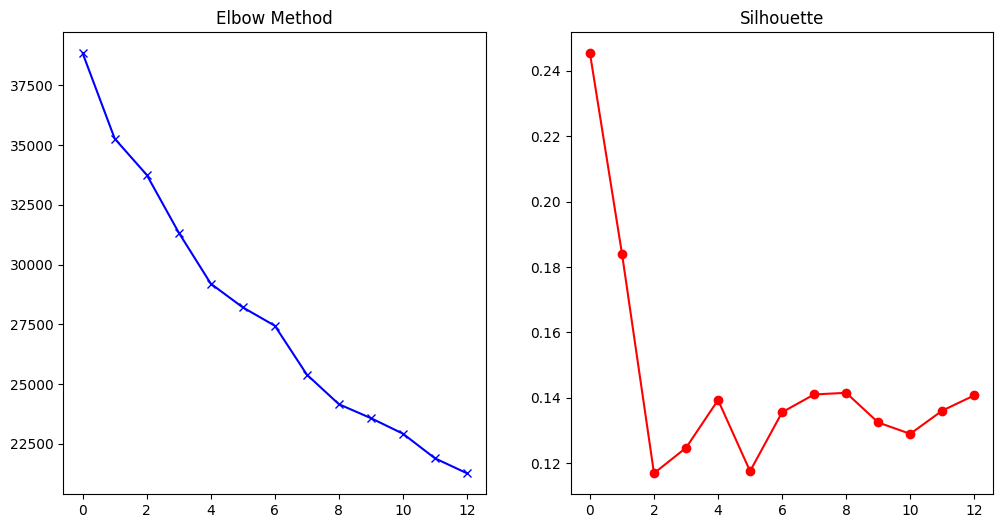

In [9]:
# Encontrar K 
WCSS = [] #Suma de las distancias totales
silhouette = [] #Mejores resutlados con diferentes k
K = range(2, 15) #Cantidad de k a usar 

#Probar las diferentes k
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42)
    cluster_km = k_means.fit_predict(X_standr)
    WCSS.append(k_means.inertia_)
    silhouette.append(silhouette_score(X_standr, cluster_km))

#Graficación de los dos metodos 
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

#Graficacion primer metodo
axes[0].plot(WCSS, 'b-x')
axes[0].set_title('Elbow Method')

#Graficacion Segundo metodo
axes[1].plot(silhouette, 'r-o')
axes[1].set_title('Silhouette')

plt.show()

##### Recomendado para este caso k = 2

In [10]:
k_means = KMeans(n_clusters=2, random_state=42)
cluster_km = k_means.fit_predict(X_standr)
coeficientes['K_means'] = silhouette_score(X_standr, cluster_km)
print(f'Coeficiente para k_means {silhouette_score(X_standr, cluster_km)}')

Coeficiente para k_means 0.24529426044894284


## K-Means con PCA

Text(0.5, 1.0, 'Sillhouette Method PCA')

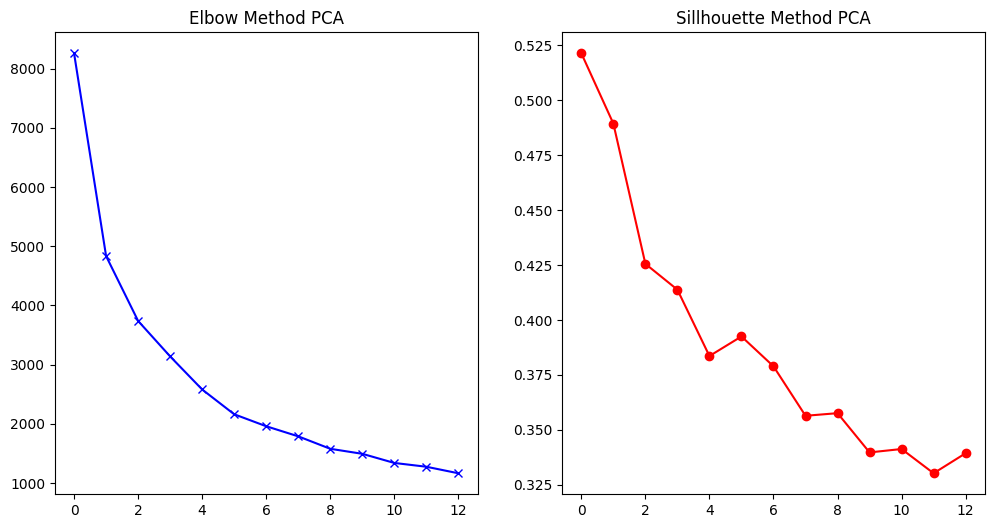

In [11]:
#Volver a realizar los dos metodos de evaluacion
WCSS = []
silhouette = []

for k in K:
    k_means_pca = KMeans(n_clusters=k, random_state=42)
    cluster_km_pca = k_means_pca.fit_predict(X_pca)
    WCSS.append(k_means_pca.inertia_)
    silhouette.append(silhouette_score(X_pca,cluster_km_pca))

#Graficar
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

#Metodo 1
axes[0].plot(WCSS, 'b-x')
axes[0].set_title('Elbow Method PCA')

#Metodo 2
axes[1].plot(silhouette, 'r-o')
axes[1].set_title('Sillhouette Method PCA')

#### al igual que en el anterior tambien nos sugiere aplicar 2 clusters pero podemos ver como hay una mejoria significativa tanto en elbow como en el coeficiente de silueta

In [12]:
k_means_pca = KMeans(n_clusters=2, random_state=42)
cluster_km_pca = k_means_pca.fit_predict(X_pca)
coeficientes['K_means_pca'] = silhouette_score(X_pca, cluster_km_pca)
print(f'Coeficiente para k_means_pca {silhouette_score(X_pca, cluster_km_pca)}')

Coeficiente para k_means_pca 0.5213706446883846


## Herarchical Clustering sin PCA

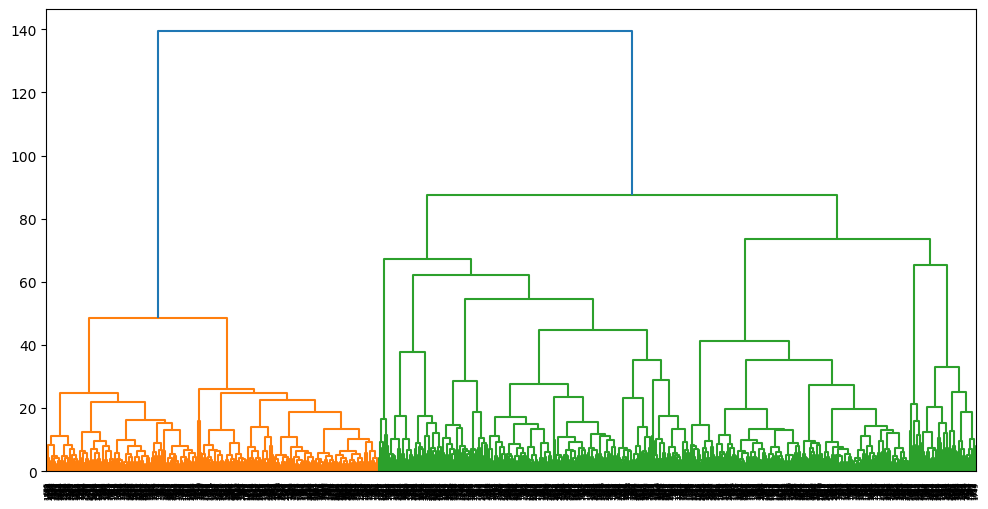

In [13]:
#Relizamos la visualizacion del dendograma
plt.figure(figsize=(12, 6))
dendogram = dendrogram(linkage(X_standr, method='ward'))

#### El dendograma nos indica cuales serían los optimos clusters basandose en donde mejor se puede separar este, en este caso serían 3 cluster

In [14]:
#Realizamos los cluster con esto dado y conocemos su precisión
hc = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
cluster_hc = hc.fit_predict(X_standr)
coeficientes['hc'] = silhouette_score(X_standr, cluster_hc)
print(f'Coeficiente para hc {silhouette_score(X_standr, cluster_hc)}')

Coeficiente para hc 0.154803943296929


## Herarchical Clustering con PCA

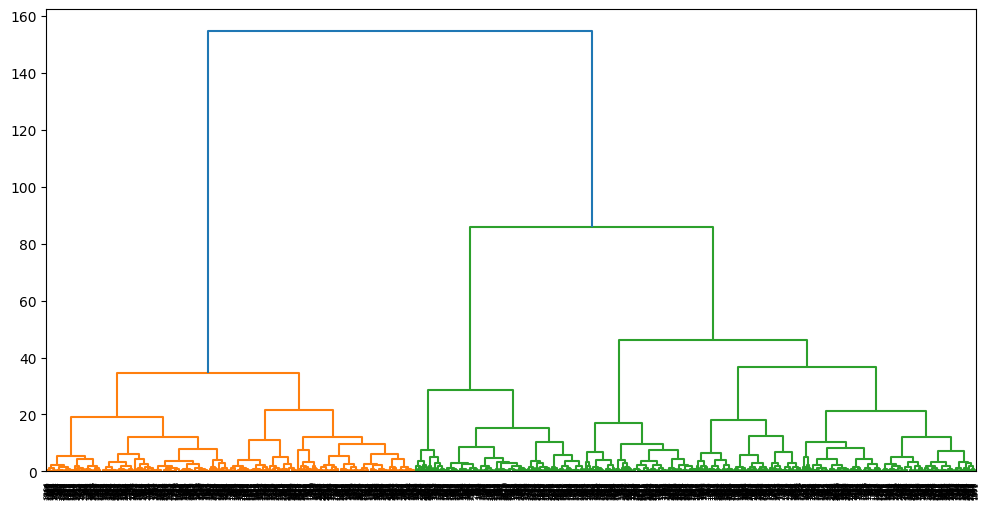

In [15]:
plt.figure(figsize=(12, 6))
dendogram = dendrogram(linkage(X_pca, method='ward'))

In [16]:
#En esta parte realizamos el mismo procedimiento pero con valores de pca para ver su mejoria
hc_pca = AgglomerativeClustering(n_clusters=3)
cluster_hc_pca = hc_pca.fit_predict(X_pca)
coeficientes['hc_pca'] = silhouette_score(X_pca, cluster_hc_pca)
print(f'Coeficiente para hc_pca {silhouette_score(X_pca, cluster_hc_pca)}')

Coeficiente para hc_pca 0.4610807302874904


## DBSCAN sin pca

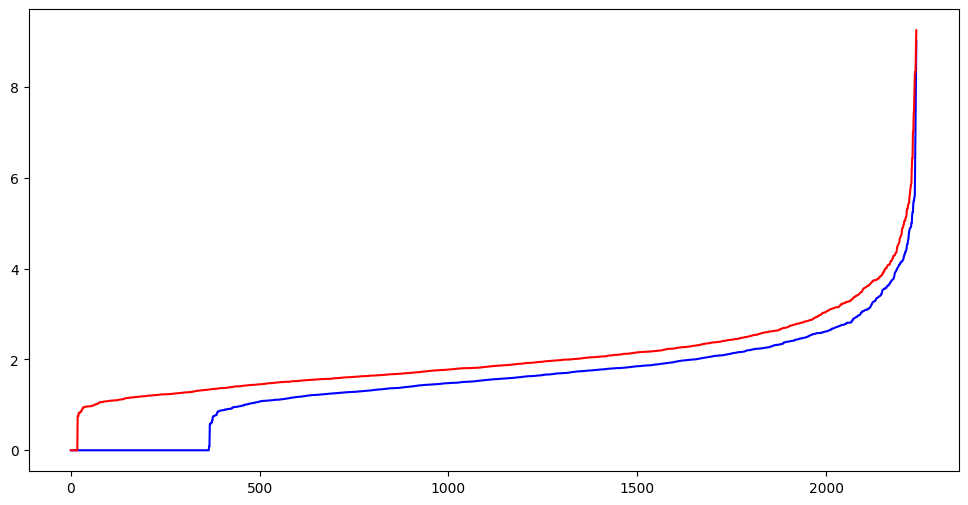

In [17]:
# Realizamo metodo knee o rodilla para ver posibles epsilon donde empieza a crecer con sus vecinos mas cercanos 
vecinos = NearestNeighbors(n_jobs=2)
vecinos.fit(X_standr)
#Obtenemos los puntso mas cercanos a cada dato
distancia, indice = vecinos.kneighbors(X_standr)
#ponemos las distancias de manera acendente 
distancia = np.sort(distancia, axis=0)

#Graficamos 
plt.figure(figsize=(12, 6))
#Valores mas cercanos 
plt.plot(distancia[:, 1], color='b')
#Segundos valores mas cercanos
plt.plot(distancia[:, 2], color='r')
plt.show()

#### hasta el momento esto nos puede decir que enre 1.5 y 2.0 está un posible epsilon esto se basa basandose en las distancias con los mas cercanos

In [18]:
#Probar iterando con diferntes cantidas para mirar n_custers y mejores coeficinte de silueta 

#Diferentes epislons y minimos de puntos a probar
eps_iter = np.arange(0.5, 2.0, 0.1)
min_points = np.arange(2, 50)

#Donde almacenamos la informacion durante las iteraciones
silhouette_dbscan = []
numero_clusters = []

#Lista a iterar
dbscan_params = list(product(eps_iter, min_points))

#Iteraciones para probar los parametros

for v in dbscan_params:
    dbscan = DBSCAN(eps=v[0], min_samples=v[1])
    cluster_dbscan = dbscan.fit_predict(X_standr)
    #Durante estos proceso si el epsilon y los minimos de puntos , llegan a no ser los mas optimos puede generar un cluster solamente lo que daría error respecto a como se calcula el coeficiente de silueta así que manejamos el erorr por si llega a pasar
    try:
        silhouette_dbscan.append(silhouette_score(X_standr, cluster_dbscan))
    except:
        silhouette_dbscan.append(0)
    numero_clusters.append(len(np.unique(cluster_dbscan)))

In [19]:
#Realizar las tablas para poder intepretar mejor la información 
resultados = pd.DataFrame().from_records(dbscan_params, columns=['eps', 'min_points'])
resultados['silhouette'] = silhouette_dbscan
resultados['n_clusters'] = numero_clusters

#Realizar tablas
pivote1 = pd.pivot_table(data=resultados, columns='eps', index='min_points', values='silhouette')
pivote2 = pd.pivot_table(data=resultados, columns='eps', index='min_points', values='n_clusters')

Text(0.5, 1.0, 'Numero de clusters')

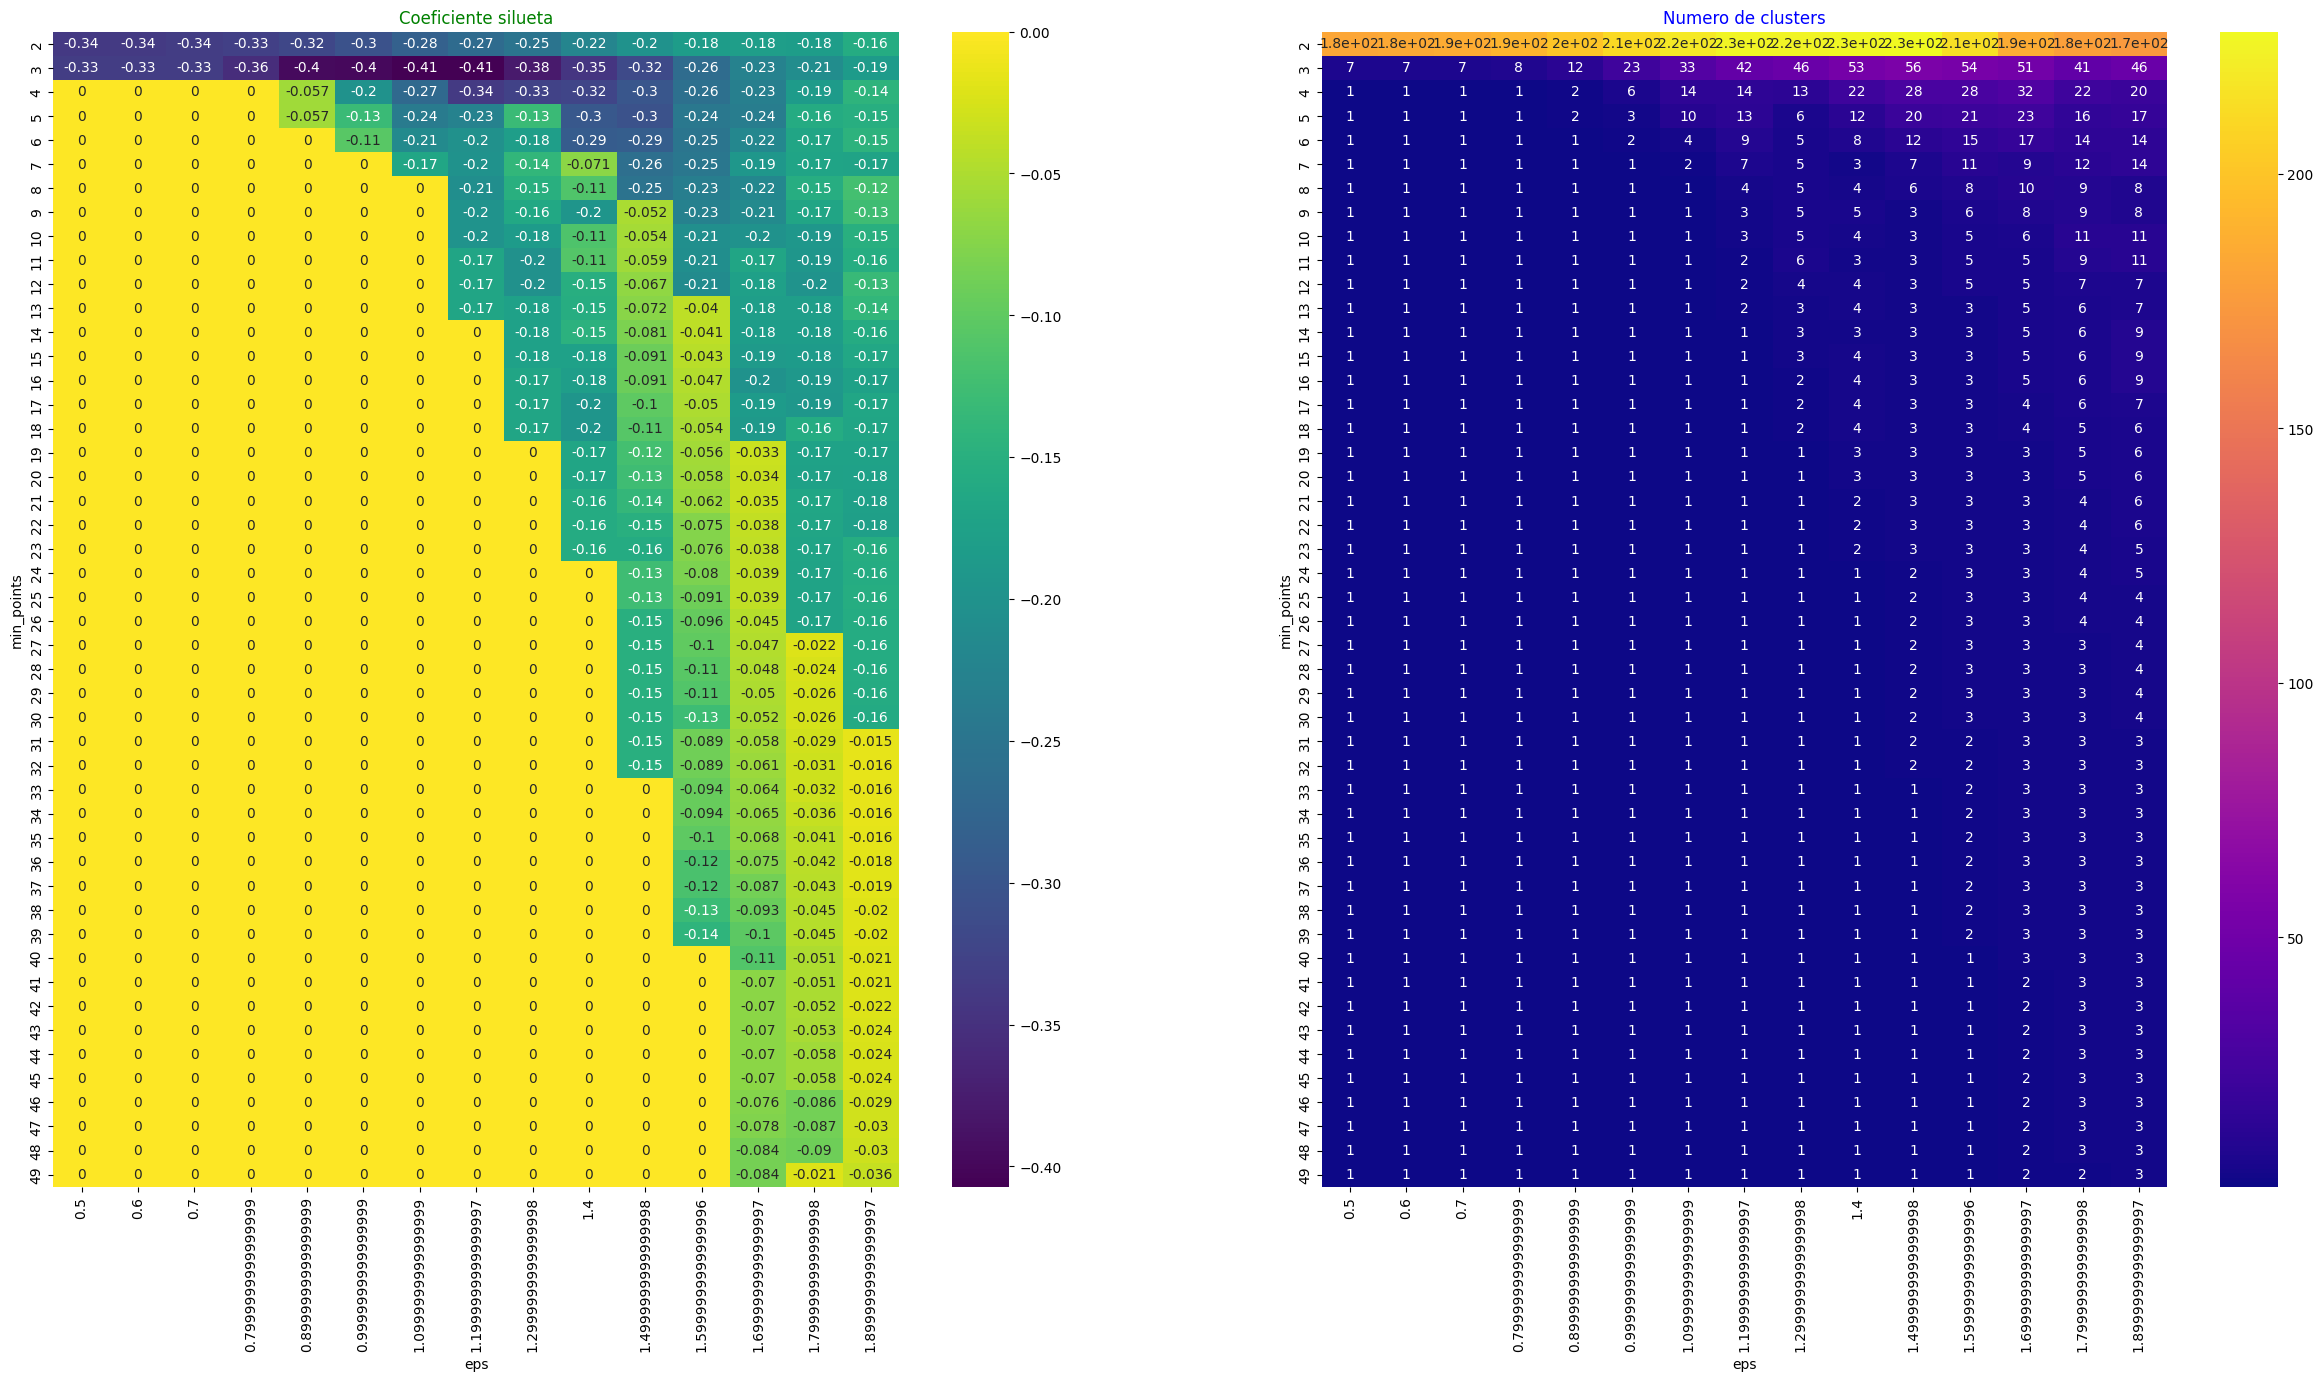

In [20]:
#Relizar graficaciones

fig, axes = plt.subplots(1, 2, figsize=(30, 15))

sns.heatmap(pivote1,annot=True, annot_kws={'size': 10}, ax=axes[0], cmap='viridis')
axes[0].set_title('Coeficiente silueta', color='green')

sns.heatmap(pivote2, annot=True, annot_kws={'size': 10}, ax=axes[1], cmap='plasma')
axes[1].set_title('Numero de clusters', color='blue')

#### En estos ejemplos no obtenemos ningun resultado positivo que pueda servir, esto se puede deber a ruido dentro de los datos

## DBSCAN con PCA

In [21]:
#Probar de nuevo con PCA
eps_iter_pca = np.arange(0.5, 2.0, 0.1)
min_points_pca = np.arange(2, 50)

silhouette_dbscan_pca = []
numero_clusters_pca = []


dbscan_params_pca = list(product(eps_iter_pca, min_points_pca))


for v in dbscan_params_pca:
    dbscan_pca = DBSCAN(eps=v[0], min_samples=v[1])
    cluster_dbscan_pca = dbscan_pca.fit_predict(X_pca)
    #Durante estos proceso si el epsilon y los minimos de puntos , llegan a no ser los mas optimos puede generar un cluster solamente lo que daría error respecto a como se calcula el coeficiente de silueta así que manejamos el erorr por si llega a pasar
    try:
        silhouette_dbscan_pca.append(silhouette_score(X_pca, cluster_dbscan_pca))
    except:
        silhouette_dbscan_pca.append(0)
    numero_clusters_pca.append(len(np.unique(cluster_dbscan_pca)))

In [22]:
resultados_pca = pd.DataFrame().from_records(dbscan_params_pca, columns=['eps', 'min_points'])
resultados_pca['silhouette'] = silhouette_dbscan_pca
resultados_pca['n_clusters'] = numero_clusters_pca

#Realizar tablas
pivote1_pca = pd.pivot_table(data=resultados_pca, columns='eps', index='min_points', values='silhouette')
pivote2_pca = pd.pivot_table(data=resultados_pca, columns='eps', index='min_points', values='n_clusters')

Text(0.5, 1.0, 'Numero de clusters con pca')

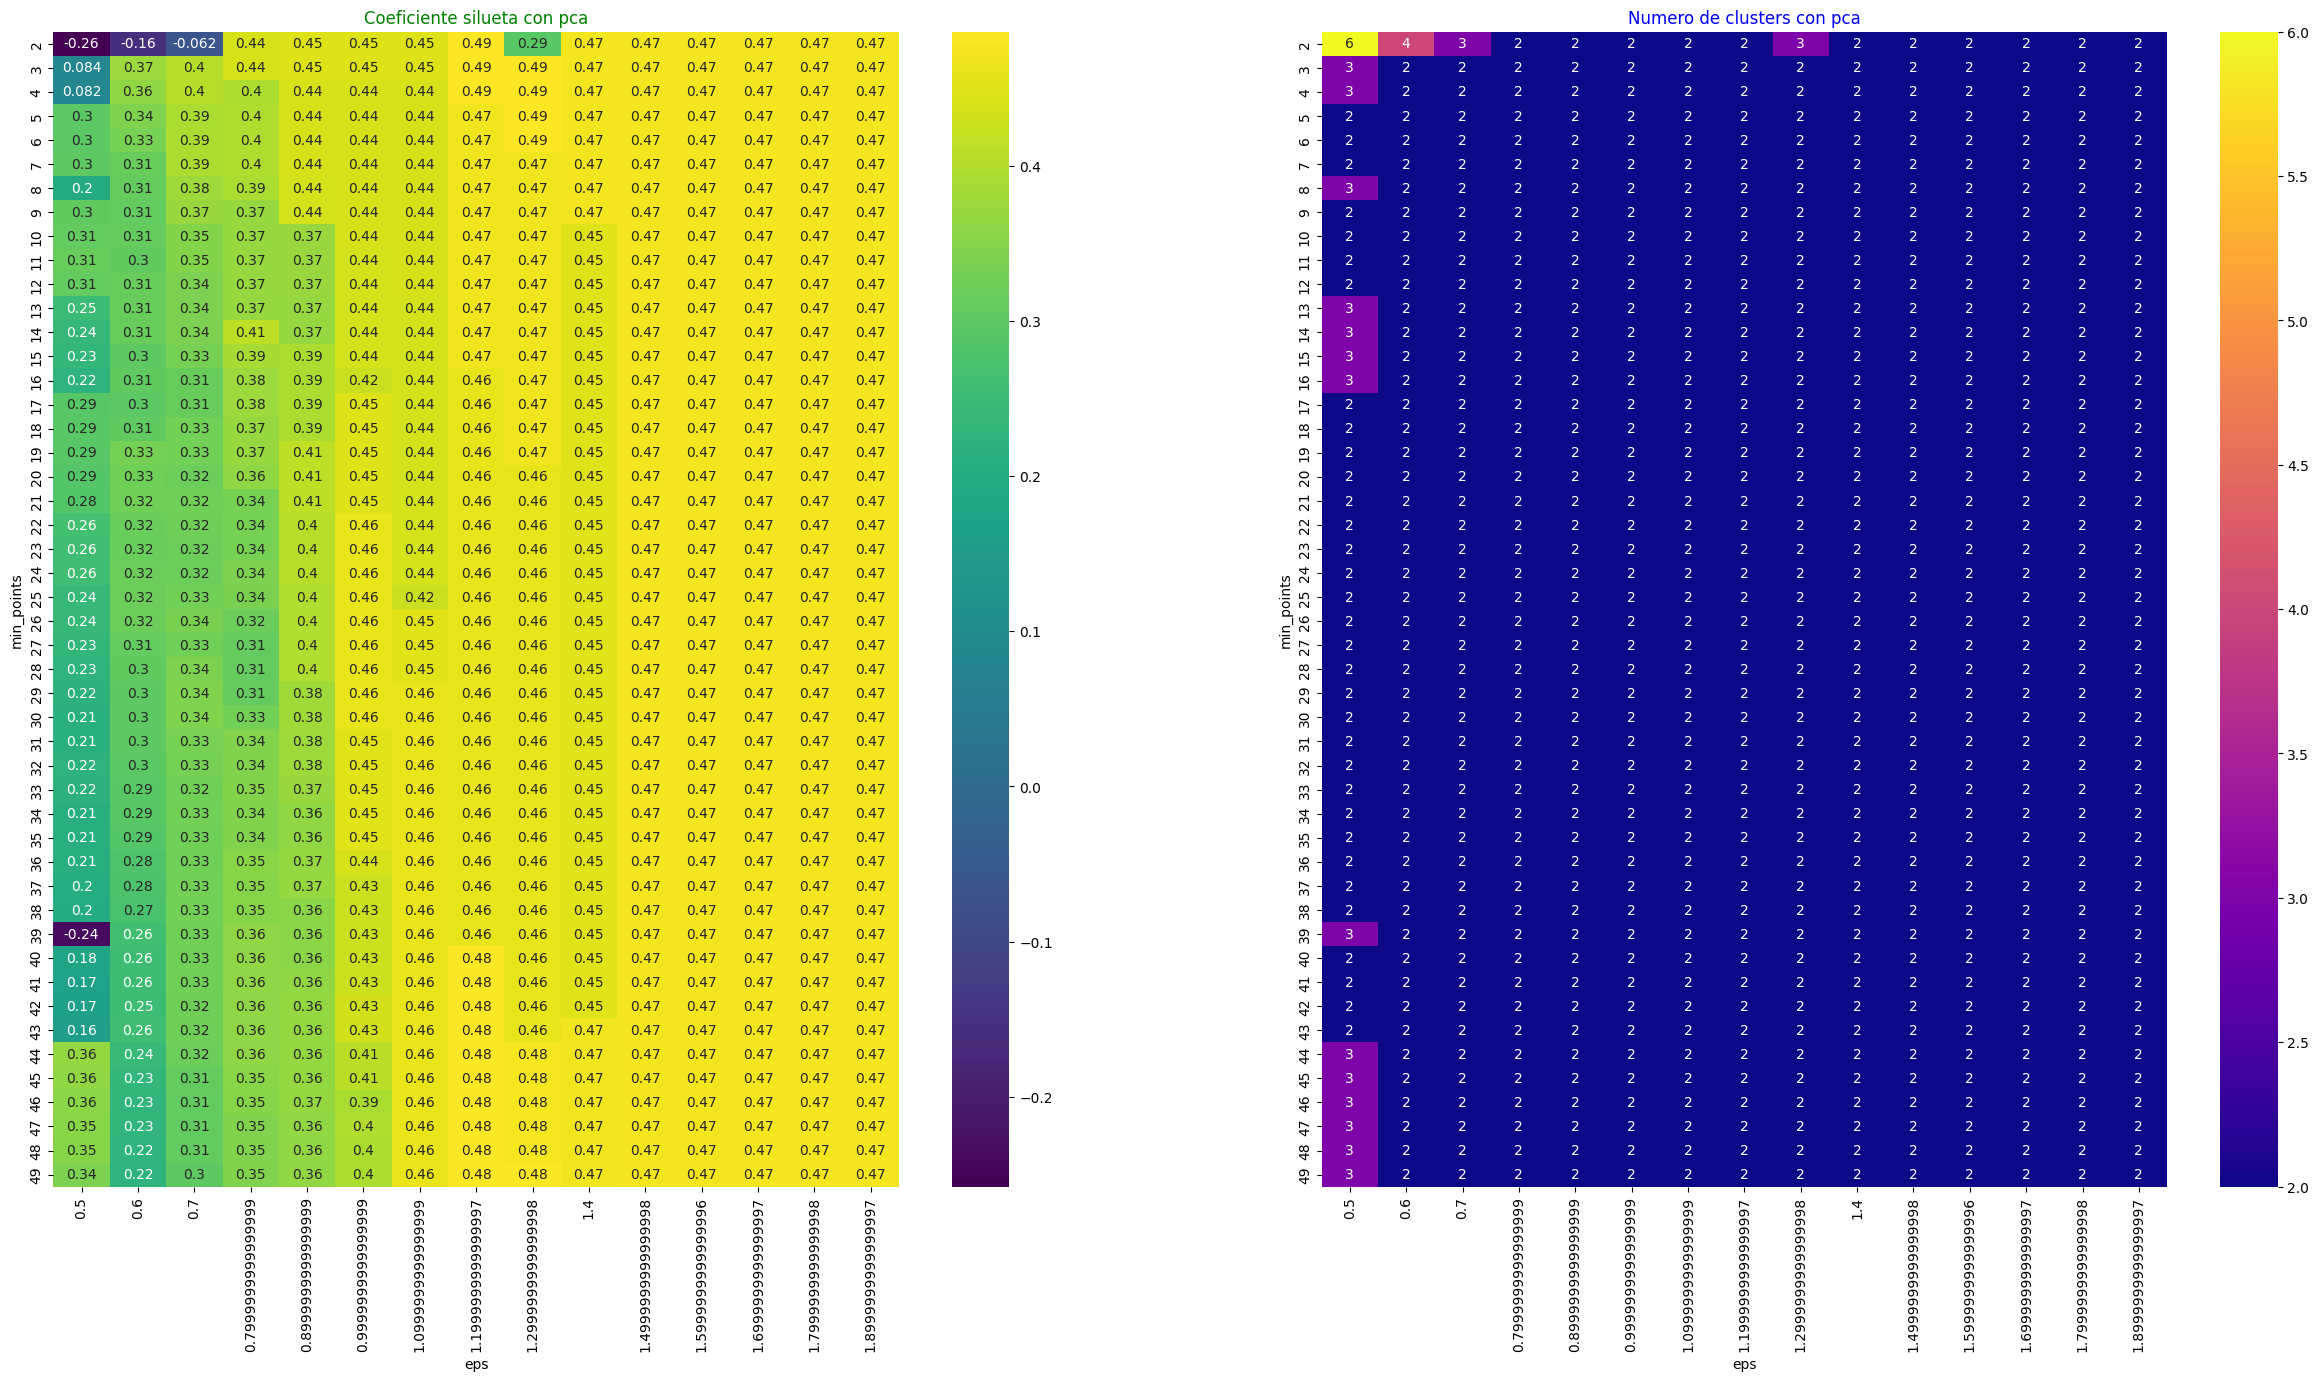

In [23]:
#Relizar graficaciones

fig, axes = plt.subplots(1, 2, figsize=(30, 15))

sns.heatmap(pivote1_pca,annot=True, annot_kws={'size': 10}, ax=axes[0], cmap='viridis')
axes[0].set_title('Coeficiente silueta con pca', color='green')

sns.heatmap(pivote2_pca, annot=True, annot_kws={'size': 10}, ax=axes[1], cmap='plasma')
axes[1].set_title('Numero de clusters con pca', color='blue')

#### Como los demas modelos tenemos una mejora tambien con 1.2 de eps y minimo 3 de puntos cercanos

In [24]:
dbscan_pca = DBSCAN(eps=1.2, min_samples=3)
cluster_dbscan_pca = dbscan_pca.fit_predict(X_pca)
coeficientes['dbscan_pca'] = silhouette_score(X_pca, cluster_dbscan_pca)
print(f'Coeficiente para dbscan_pca {silhouette_score(X_pca, cluster_dbscan_pca)}')

Coeficiente para dbscan_pca 0.4863932881236303


# Evaluar resultados

In [31]:
coeficientes

{'K_means': 0.24529426044894284,
 'K_means_pca': 0.5213706446883846,
 'hc': 0.154803943296929,
 'hc_pca': 0.4610807302874904,
 'dbscan_pca': 0.4863932881236303}

In [32]:
resultados_global = pd.DataFrame([coeficientes])
resultados_global

,K_means,K_means_pca,hc,hc_pca,dbscan_pca
0,0.245294,0.521371,0.154804,0.461081,0.486393


#### Implementaremos un K_means_pca que tuvo mejor performance